# Obstacle model

Obstacles can modify the wind speed at the height where the wind turbine is implemented.
Such wind speed reduction can be analytically computed.

Wind-stats implements the **WEMOD algorithm**.

Using [*Peña, A., Bechmann, A., Conti, D., Angelou, N., & Troen, I. (2015). Shelter models and observations*](https://orbit.dtu.dk/en/publications/shelter-models-and-observations) which outlines the different Shelter models. 

Tests cases which can be found in this publication are computed with **wind-stats** for validation.

## WEMOD Shelter algorithm

Algorithm based on Taylor, P. A. and J. R. Salmon, 1993.

$\frac{\Delta u_{s,i}(z)}{u_0(z)} = \Gamma \tilde{C_h} \left(\frac{w_i}{h}\right) \left(\frac{x_i}{h}\right)^{-1.5} G(\zeta_i) F(\lambda_i)$

$\Gamma = 12.1875$

$\kappa \approx 0.4$

$c_a = [ln(h/z_0)/(2κ^2)]^{1/(n+2)}$, $a_g = 0.67c_a^{1.5}$

$G(\zeta) = c_a\zeta e^{-a_g\cdot\zeta^{1.5}}$

$\zeta = \left(\frac{z}{h}\right) \left(\frac{x}{h}\right)^{-1/(n+2)}$

## 2D infinite porous fence

 - Fence of 2000 m facing North
 - $h/z_{0} = 100$
 - $z/h = 0.5$
 - porosity $\varphi = 0.1$

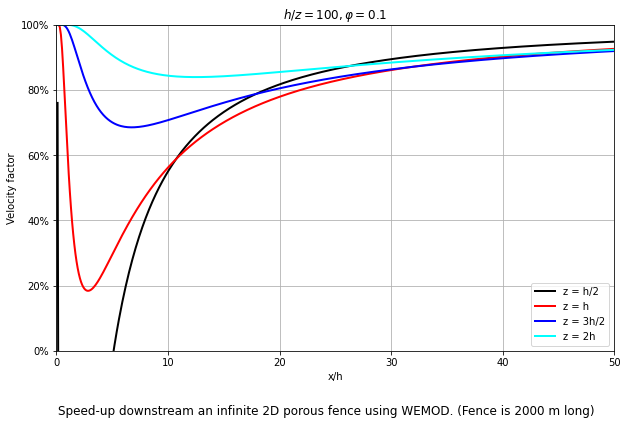

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import PercentFormatter

from wind_stats.utils import wemod_wind_speed_reduction

plt.figure(figsize=(10,6))

h = 1
distance = np.linspace(0.1, 50, 500) * h

z0 = h/100

# compute normalized wake coefficient from porosity.
C_h = 0.8*(1-0.1)

colors = ["black", "red", "blue", "cyan"]
labels = ["h/2", "h", "3h/2", "2h"]

# Plot wind speed up at x/h for 3 diferent height ratio z/h.
for z, color, label in zip([h/2, h, 3*h/2, 2*h], colors, labels):
    reduction = [wemod_wind_speed_reduction(-1000, x , 1000, x, h, z, z0, C_h)  for x in distance]
    plt.plot(distance / h, 1 - np.array(reduction), color=color, linewidth=2, label=f'z = {label}')

plt.ylim(0,1)
plt.xlim(0,50)
plt.grid(True)
plt.ylabel("Velocity factor")
plt.xlabel("x/h")
plt.legend()
ax = plt.gca()
plt.title(r"$h/z = 100, \varphi = 0.1$")
plt.suptitle("""Speed-up downstream an infinite 2D porous fence using WEMOD. (Fence is 2000 m long)""",y=0)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.show()

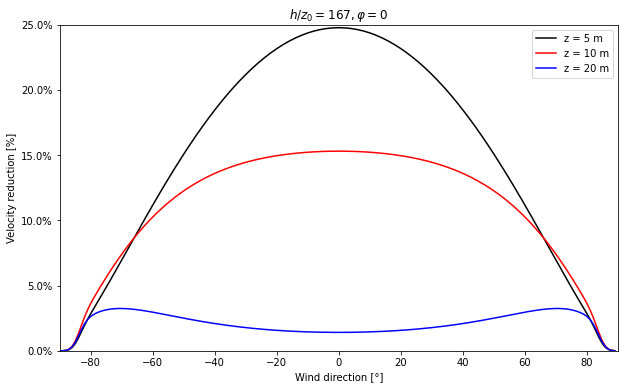

In [2]:
# 2km long - 5m high fence facing North
x_L, y_L = (-1000, 100)
x_R, y_R = (1000, 100)
angles = np.arange(-90, 90)

# height 5 m
h = 5

# roughness 0.03 m
z0 =  0.03

colors = ["black", "red", "blue"]
plt.figure(figsize=(10,6))
for z, color in zip([5, 10, 20], colors):
    wind_reduction = wemod_wind_speed_reduction(x_L, y_L, x_R, y_R, h, z , z0, 0.8, angles)
    plt.plot(angles, wind_reduction, color=color, label=f'z = {z} m')
    
plt.ylim(0, 0.25)
plt.xlim(-90, 90)
plt.xlabel("Wind direction [°]")
plt.ylabel("Velocity reduction [%]")
plt.legend()
plt.title(r"$h/z_0 = 167, \varphi = 0$")
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.show()

In [3]:
# Height 1
h = 1

# x/h [0 ... 50]
x_h = np.linspace(0.001,50, 400)
# z/h [0 ... 5]
z_h = np.linspace(0.001,5, 400)

x = x_h * h
z = z_h * h

# Meshgrid x, z
xx, zz = np.meshgrid(x,z)
z0 = h / 100
vfunc = np.vectorize(wemod_wind_speed_reduction)
reduction = vfunc(-1000, xx , 1000, xx, h, zz, z0, C_h = 0.8)
# Filter speed reduction over 100%
reduction = np.where(reduction > 1, np.nan, reduction)

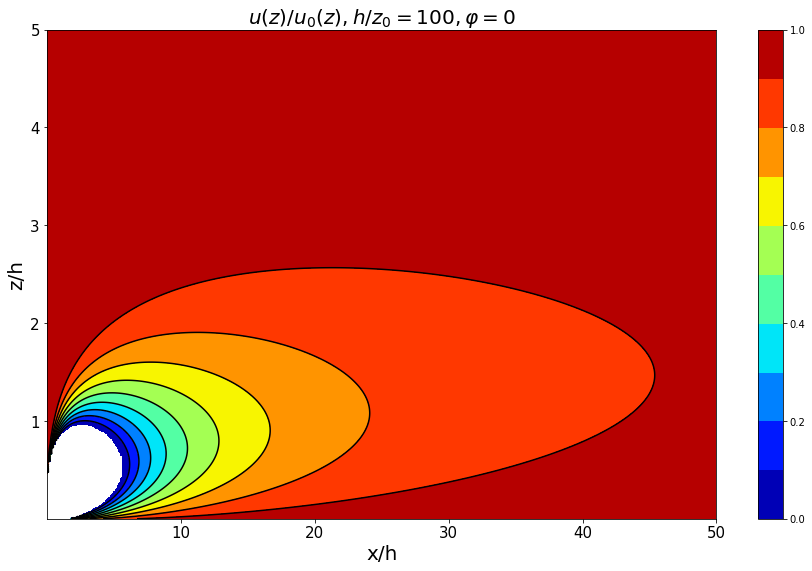

In [4]:
plt.figure(figsize=(15,9))
plt.contour(x_h,z_h,1 - reduction, colors=["black"], vmin = 0, vmax = 1, levels = 10)
plt.contourf(x_h,z_h,1 - reduction, cmap="jet", vmin = 0, vmax = 1, levels = 10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("x/h", fontsize=20)
plt.ylabel("z/h", fontsize=20)
plt.title(r"$u(z)/u_0(z), h/z_0 = 100, \varphi = 0$", fontsize=20)
plt.colorbar()
plt.show()

In [6]:
h = 1
x_h = np.linspace(0.2,12,400)
y_h = np.linspace(-2,2,400)

x = x_h * h
y = y_h * h

xx, yy = np.meshgrid(x,y)
z0 = h / 100
vfunc = np.vectorize(wemod_wind_speed_reduction)

from wind_stats.geometry import translate

# Extreme points of the obstacle
x_L = 0
y_L = -h/2
x_R = 0
y_R = h/2

z=h/2

# Compute extreme points in the point of interest as origin.
new_x_r, new_y_r = translate((-x, -y), x_R, y_R)
xxR, yyR = np.meshgrid(new_x_r,new_y_r)
new_x_L, new_y_L = translate((-x, -y), x_L, y_L)
xxL, yyL = np.meshgrid(new_x_L,new_y_L)

reduction = vfunc(xxL, yyL , xxR, yyR, h, z, z0, C_h = 0.8, wind_angle=270)

reduction = np.where(reduction > 1, np.nan, reduction)

In [11]:
h = 1
x_h = np.linspace(0,12,400)
y_h = np.linspace(-2,2,400)

x = x_h * h
y = y_h * h

xx, yy = np.meshgrid(x,y)
z0 = h / 100
vfunc = np.vectorize(wemod_wind_speed_reduction)

from wind_stats.geometry import translate

# Extreme points of the obstacle
x_L = 0
y_L = -h/2
x_R = 0
y_R = h/2

z=h/2

reduction = vfunc(x_L, y_L , x_R, y_R, h, z, z0, C_h = 0.8, wind_angle=270, x_offset=xx, y_offset=yy)

reduction = np.where(reduction > 1, np.nan, reduction)

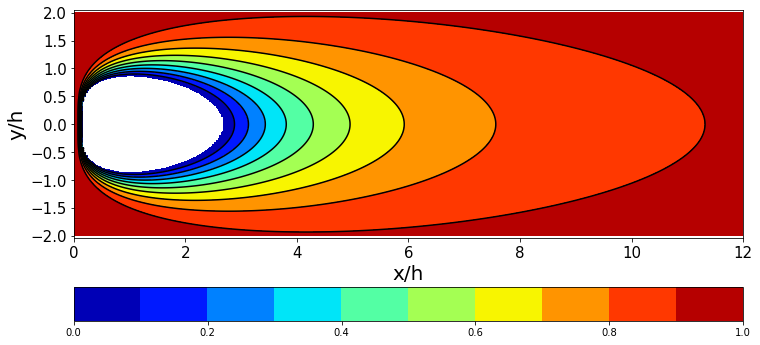

In [12]:
plt.figure(figsize=(12,6))
plt.contour(x_h,y_h,1 - reduction, colors=["black"], vmin = 0, vmax = 1, levels = 10)
plt.contourf(x_h,y_h,1 - reduction, cmap="jet", vmin = 0, vmax = 1, levels = 10)
plt.colorbar(orientation="horizontal")
plt.axis("equal")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("x/h", fontsize=20)
plt.ylabel("y/h", fontsize=20)
plt.show()